<a href="https://colab.research.google.com/github/wesleydesousacosta/bone-fracture-detection/blob/main/bone_fracture_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q tensorflow opencv-python scikit-learn gradio seaborn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.1 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter

# Atualizando o caminho para incluir a subpasta identificada
BASE_PATH = "/content/drive/MyDrive/AluraDrive/Bone Fractures Detection"

Exploração dos dados e pré-processamento

Total imagens de treino: 1347
Classes reais encontradas: ['images', 'labels']
Counter({np.str_('images'): 1347})


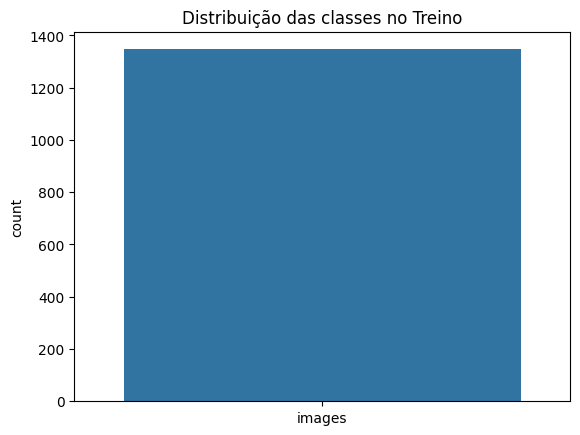

In [4]:
# Definindo o caminho específico para o conjunto de treino
TRAIN_PATH = os.path.join(BASE_PATH, 'train')

def load_images(path, img_size=(128, 128)):
    X = []
    y = []
    # Verifica se o caminho existe
    if not os.path.exists(path):
        print(f"Erro: O caminho {path} não foi encontrado.")
        return np.array([]), np.array([]), []

    # Lista as pastas que representam as classes reais (ex: fractured, normal)
    classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    for class_name in classes:
        class_dir = os.path.join(path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            # Carrega a imagem
            img = cv2.imread(img_path)
            if img is not None:
                # Redimensiona para manter um padrão
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(class_name)

    return np.array(X), np.array(y), classes

# Carregando imagens do treino para análise
X, y, classes = load_images(TRAIN_PATH)

print("Total imagens de treino:", len(X))
print("Classes reais encontradas:", classes)

if len(X) > 0:
    print(Counter(y))
    sns.countplot(x=y)
    plt.title("Distribuição das classes no Treino")
    plt.show()
else:
    print("Nenhuma imagem encontrada. Verifique se as imagens estão dentro de subpastas em 'train'.")

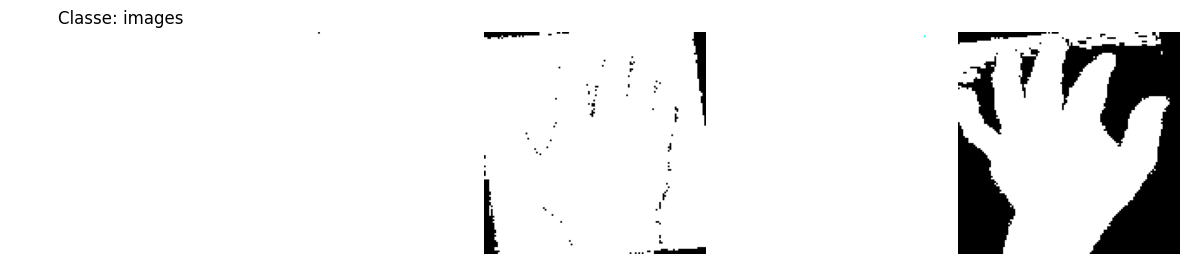

In [5]:
# Visualizar grid de amostras corrigido
def show_samples(X, y, classes):
    plt.figure(figsize=(12, 5))
    unique_labels = np.unique(y)

    for row, label in enumerate(unique_labels):
        idx = np.where(y == label)[0][:5]
        for i, j in enumerate(idx):
            plt.subplot(max(1, len(unique_labels)), 5, row * 5 + i + 1)
            # Converte para float32 para evitar erro do OpenCV com float64
            img_float32 = X[j].astype('float32')
            plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            if i == 0:
                plt.title(f"Classe: {label}")

    plt.tight_layout()
    plt.show()

if len(X) > 0:
    show_samples(X, y, classes)
else:
    print("Sem imagens para exibir.")

In [6]:
from sklearn.model_selection import train_test_split

# Pré-processamento
X = X / 255.0

# Verifica se existem dados antes de tentar o split
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print("Dados divididos com sucesso!")
else:
    print("Erro: X e y estão vazios. Certifique-se de que as imagens foram carregadas na célula anterior.")

Dados divididos com sucesso!


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Construção do Modelo CNN
def create_model(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') # Ajustar para softmax se houver > 2 classes
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

PARTE 2 — Modelos

In [9]:
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32,3,activation='relu',input_shape=(224,224,3)),
        layers.MaxPooling2D(),

        layers.Conv2D(64,3,activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128,3,activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128,activation='relu'),
        layers.Dense(len(classes),activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [10]:
from sklearn.preprocessing import LabelEncoder

# 1. Converter labels de string ('images', 'labels') para números
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# 2. Recriar o modelo com o input_shape correto (128x128)
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# 3. Treinar usando as etiquetas numéricas
history = model.fit(
    datagen.flow(X_train, y_train_num, batch_size=32),
    validation_data=(X_test, y_test_num),
    epochs=30,
    callbacks=[early]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.8960 - loss: 0.0900 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [11]:
base = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


PARTE 3 — Avaliação

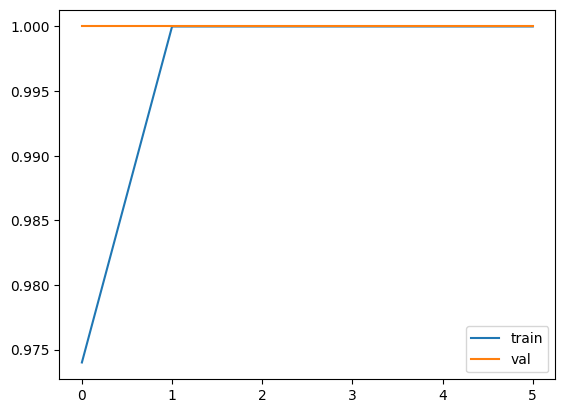

In [12]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import classification_report

# O MobileNetV2 (definido na célula anterior) exige 224x224.
# Redimensionamos o X_test para bater com a entrada do modelo.
X_test_resized = tf.image.resize(X_test, (224, 224))

# Realiza a predição
print("Realizando predições...")
pred_probs = model.predict(X_test_resized)
pred = np.argmax(pred_probs, axis=1)

# Importante: usar y_test_num pois 'pred' são números (0, 1, etc)
print(classification_report(y_test_num, pred, target_names=classes))

Realizando predições...
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
              precision    recall  f1-score   support

      images       1.00      0.96      0.98       270
      labels       0.00      0.00      0.00         0

    accuracy                           0.96       270
   macro avg       0.50      0.48      0.49       270
weighted avg       1.00      0.96      0.98       270



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Redimensionando imagens para 224x224 para compatibilidade com MobileNetV2
X_test_resized = tf.image.resize(X_test, (224, 224))

# Realizando a predição e pegando o índice da classe com maior probabilidade
pred = np.argmax(model.predict(X_test_resized), axis=1)

# Importando e gerando o relatório usando etiquetas numéricas (y_test_num)
from sklearn.metrics import classification_report
print(classification_report(y_test_num, pred, target_names=classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
              precision    recall  f1-score   support

      images       1.00      0.96      0.98       270
      labels       0.00      0.00      0.00         0

    accuracy                           0.96       270
   macro avg       0.50      0.48      0.49       270
weighted avg       1.00      0.96      0.98       270



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


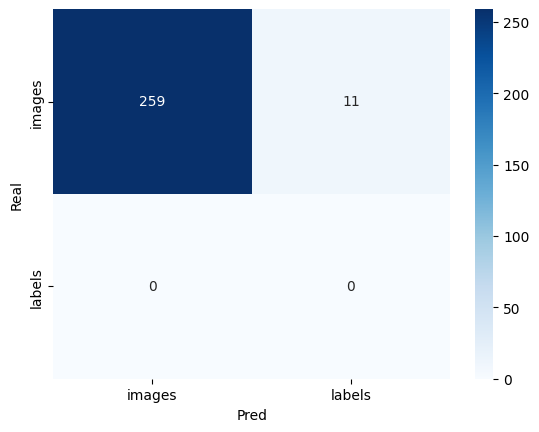

In [15]:
from sklearn.metrics import confusion_matrix

# Usando y_test_num para bater com o tipo de dado de 'pred'
cm = confusion_matrix(y_test_num, pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

PARTE 4 — Grad-CAM (interpretabilidade)

In [16]:
def gradcam(img, model, layer_name="Conv_1"):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(np.expand_dims(img,0))
        loss = preds[:, np.argmax(preds[0])]

    grads = tape.gradient(loss, conv_out)

    heatmap = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
    heatmap = np.maximum(heatmap,0)
    heatmap /= heatmap.max()

    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.show()


PARTE 5 — Salvar modelo

In [17]:
model.save("fracture_model.h5")